# Inscopix Tech Project


Andy Henrie, 13Nov,2020
start:  10:00pm
end:  3:00pm

start: (17Nov) 9:30am
end: 12:30pm  (Plus some time packaging / cleaning)

# Assignment

    Determine if there is a relationship between the external events in `triggers.csv` and the neural data in the `ca_data` csv files. If there is a relationship, characterize it. Consider the 4 `ca_data` csv files as independent experiments and evaluate any relationships between external events and neural data across this sample. The "external events" are onsets of some behavior of interest.


# General Approach

I employ a standard data science pipeline approach:  IMPORT/PREP -> EXPLORE -> ANALYZE/MODEL -> INTERPRETATION as summarized below.  

### Summary

0. BASIC DATA/EDA: 
    - This is a data summary and some top-level descriptive statistics
    - Question to answer: What is the context, and what are the data? i.e.
        - 4 Experiments
        - 49-109 "neurons" or channels per experiment
        - 86 "events" per experiment
        

1. FIRST-PASS ANALYSIS: 
    - Zeroth order attempts to find the retularities in the data.
    - Null Hypothesis:  Signals are independent of to the behavioral events.
    - Question to answer is:  Are the signals related to behavioral events? Can we rule out indepencence?
    - This includes 
        - peri- event triggered averages, and
        - cross-correlation
    - Baselines are created from "random" triggers as estimate of baseline variance
    

2. DEEPER-DIVE: 
    - Refine and extend to more nuanced analysis.
    - Question to answer:  How are the singals related to behavioral events, or Can we really rule out independence?
    - Deconvolve the calcium flourescnce signal to increas signal to Noise
        - OASIS library and framework
    - Consinstently inconsistent evidence for non-indepenence.


3. IMPLICAITONS & INTERPRETATIONS    
    - Deconvolving the Calcium flourescnce signal increases Signal to Noise (S/N).  This technique uses some physical constraints from flourescence and Ca dynamics to model underlying neural signals.  Utilizing more a-priori knowledge helps!
    - The overall results were inconclusive.  Experiment #3 seemed to have some reliable event related signal (black trace lower right panel), but additional analysis are needed to confirm and characterize the relationship.

    ![triggered average experiemnt #3](triggered_resp_simple_DeconvSummary_expt3.png)

    - The assumptions taken here of _averaging_ across channels (neurons) is naive.  Each neuron should be treated independently in further analysis.




4. NEXT-STEPS: 
    - Cherry-pick channels with sufficient S/N to conclusively rule out the null hypothesis of indepencence between "behavioral events" and the neural recordings. 
    - Developing a framework for analyzing individual channels opens up some potentially powerful analyses such as network analysis and other techniques to look at epresentations of activity in ensembles of several neurons could be non-linearly correlated ot the behavioral events.
    - Refine the OASIS deconvolution.  Tuning the paramaters could imporove results.
    - Spectral coherence analysis. The frequency domain might be more robust for estimating the associaiton between the events and signal. 
    - Since we are operating at the limit of sigal to noise (S/N) developing a clear statistical test will be nescessary.  I have just used hueristics and rough 95% confidence intervals assuming an underlying Normal distributions to assess the null results.


5. PROVENANCE:
    - Who, What, When: record the date, time, environmental variables and environment for reproducibility
    
  

In [1]:
# generic import
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

#--------------------
import seaborn as sns

#import scipy 
import spectrum

from scipy import signal
from scipy.fft import fft, fftshift
from scipy import stats
from scipy.optimize import curve_fit

import matplotlib.colors as colors


%matplotlib inline

import warnings
warnings.simplefilter('ignore')

if not os.path.exists('oasis'):
    # notebuck must be "trust"ed
    !git clone https://github.com/j-friedrich/OASIS.git
    !mv OASIS OAsrc
    !python ./OAsrc/setup.py build_ext --inplace 
    !python ./OAsrc/setup.py clean --all
    !pip install -e ./OAsrc/
    !mv ./OAsrc/oasis oasis
    !rm -rf OAsrc
else:
    print('oasis already installed.')

from oasis.functions import deconvolve, estimate_parameters
from oasis.plotting import simpleaxis
from oasis.oasis_methods import oasisAR1, oasisAR2


oasis already installed.


In [2]:
# how to find the data
ROOT_DIR = "/Users/ergonyc/Projects/inscopix"

TRIGGER_DATA = ["triggers.csv"]
CA_DATA = ["ca_data_1.csv","ca_data_1.csv","ca_data_3.csv","ca_data_4.csv"]

## LOAD data into a simple data structure
The ammount of data is managable, so load into numpy arrays for easy access, and 
 1. Collect some top level statistics along the way. 
 2. Pickle the interim numpy data for easy access to secondary analysis.

Data variables are named:

- `neurs` - list of numpy arrays of the channel X Ca signal time series
- `behavs` = list of numpy arrays (vectors) of behavioral event times
- `summaries` which just a dictionanary with the data sizes

In [3]:
raw_data = os.path.join(ROOT_DIR,"data/raw")
interim_data = os.path.join(ROOT_DIR,"data/interim")
processed_data = os.path.join(ROOT_DIR,"data/processed")

file_name = os.path.join(interim_data,"expt.pkl")
if os.path.isfile(file_name):
    print(f"loading {file_name}")
    with open(file_name, "rb") as f:
        expt = pickle.load(f)
    neurs,behavs,summaries = expt

else:
    print(f"loading {file_name}")

    trigger_df = pd.read_csv(os.path.join(raw_data,TRIGGER_DATA[-1]))

    # for now just pack the data into an list of arrays  
    # TODO: a simple class wrapper to tidy things up
    neurs = []
    behavs = []
    summaries = []
    for i,c in enumerate(CA_DATA):
        dat = pd.read_csv(os.path.join(raw_data,c))
        neur = dat.iloc[:,1:].to_numpy() #drop first col
        event = trigger_df[c.rstrip(".csv")].to_numpy()
        num_neur = neur.shape[0]
        num_ev = event.shape[0]
        total_time = neur.shape[1]
        t0 = 0
        
        summary = {"Nchan": num_neur,
                "Nev": num_ev,
                "t0": t0,
                "t_end": total_time}
        
        neurs.append(neur)
        behavs.append(event)
        summaries.append(summary)
        
    expt = (neurs,behavs,summaries)
    #file_name = os.path.join(interim_data,"expt.pkl")
    with open(file_name, "wb") as f:
        pickle.dump(expt, f)
    
        

loading /Users/ergonyc/Projects/inscopix/data/interim/expt.pkl


# 0 - BASIC ANALYSIS

### What is the data in each "experiment"
- how many chanels of neural data, how long, and how many behavioral events?

In [4]:

Nexpt=len(summaries)
summaries

[{'Nchan': 60, 'Nev': 86, 't0': 0, 't_end': 25044},
 {'Nchan': 60, 'Nev': 86, 't0': 0, 't_end': 25044},
 {'Nchan': 109, 'Nev': 86, 't0': 0, 't_end': 25044},
 {'Nchan': 49, 'Nev': 86, 't0': 0, 't_end': 25044}]

In [5]:
neur_signal_grand = stats.describe(np.vstack(neurs).flatten())
neur_signal_grand

DescribeResult(nobs=6962232, minmax=(-9.228569984436037, 24.90062522888184), mean=0.0007737891986349833, variance=1.0070076372941148, skewness=6.046174495457532, kurtosis=58.80149306786071)

exp # 0
average signal (df/f?) is 5.566634e-04 +/- 1.257250e-03
                 range is 19.1 +/- 3.8
      average variance is 1.007301e+00 +/- 2.909781e-03
          average skew is 8.3 +/- 1.6
      average kurtosis is 94.3 +/- 39.9
exp # 1
average signal (df/f?) is 5.566634e-04 +/- 1.257250e-03
                 range is 19.1 +/- 3.8
      average variance is 1.007301e+00 +/- 2.909781e-03
          average skew is 8.3 +/- 1.6
      average kurtosis is 94.3 +/- 39.9
exp # 2
average signal (df/f?) is 1.177817e-03 +/- 1.212622e-03
                 range is 15.1 +/- 3.2
      average variance is 1.007139e+00 +/- 2.208854e-03
          average skew is 5.2 +/- 0.6
      average kurtosis is 38.1 +/- 10.1
exp # 3
average signal (df/f?) is 4.067701e-04 +/- 2.479175e-03
                 range is 15.1 +/- 3.7
      average variance is 1.005981e+00 +/- 5.012380e-03
          average skew is 2.5 +/- 1.2
      average kurtosis is 17.7 +/- 7.3


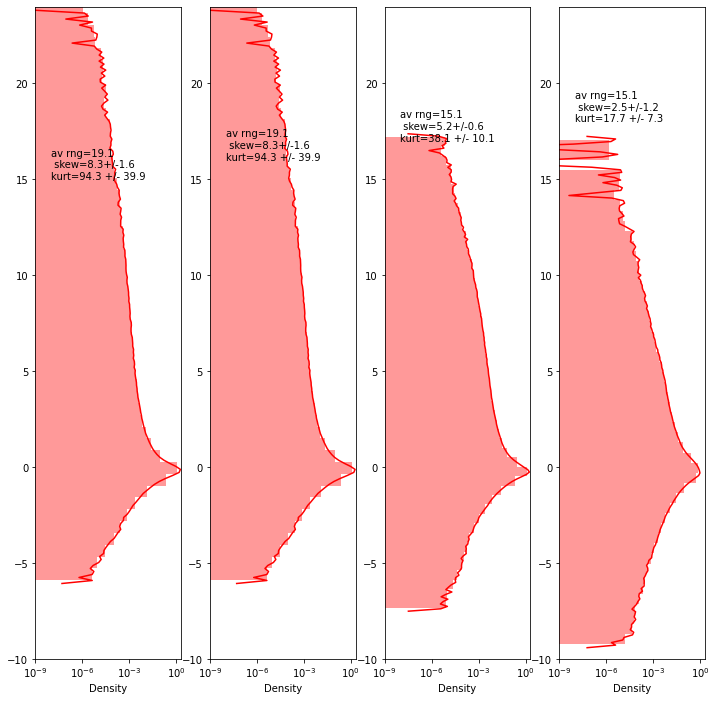

In [6]:
fig, axes = plt.subplots(figsize=(12, 12),sharey=True)
# loop over experiments
for n in range(Nexpt):
    
    X = neurs[n]
                     
    ca_data_cells = stats.describe(X, axis=1)
    mn,mx = ca_data_cells.minmax
    ca_cell_range = mx-mn                 
    ca_data_s = ca_data_cells.skewness
    ca_data_k = ca_data_cells.kurtosis
    ca_data_mu = X.mean(axis=1)
    ca_data_var = X.var(axis=1)
    print(f"exp # {n}")
    print(f"average signal (df/f?) is {ca_data_mu.mean():2e} +/- {ca_data_mu.std():2e}")
    print(f"                 range is {ca_cell_range.mean():.1f} +/- {ca_cell_range.std():.1f}")
    print(f"      average variance is {ca_data_var.mean():2e} +/- {ca_data_var.std():2e}")
    print(f"          average skew is {ca_data_s.mean():.1f} +/- {ca_data_s.std():.1f}")
    print(f"      average kurtosis is {ca_data_k.mean():.1f} +/- {ca_data_k.std():.1f}")

                 
    ax=plt.subplot(1, 4, n+1)
    stat_string = f"av rng={ca_cell_range.mean():.1f} \n "
    stat_string +=   f"skew={ca_data_s.mean():.1f}+/-{ca_data_s.std():.1f}\n"
    stat_string +=   f"kurt={ca_data_k.mean():.1f} +/- {ca_data_k.std():.1f}"
    sns.distplot(X.flatten(),vertical=True,color='red',ax=ax)
    ax.text(.00000001,15+n,stat_string)
    ax.set_xlim(0.000000001,2.)
    ax.set_ylim(-10.,24.)
    ax.set_xscale("log")
    

## Neural Signal (Ca DeltaF/F) STATS & Behavioral Event STATS
    
How are our signals distributed?   


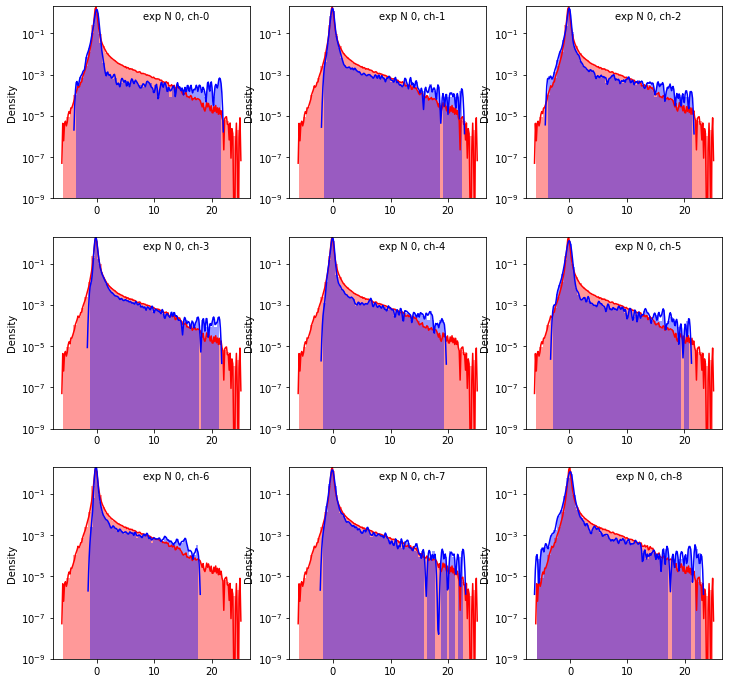

In [7]:
# inspect a few individual neural signals compared to grand average
exp_n = 0    
X = neurs[exp_n]
n_examples = 9

fig, axes = plt.subplots(figsize=(12, 12),sharey=True,sharex=True)
for i in range(n_examples):
    ax=plt.subplot(3, 3, i+1)
    sns.distplot(X.flatten(),color='red',ax=ax)
    sns.distplot(X[i,:],color='blue',ax=ax)
    ax.text(8,.5,f"exp N {exp_n}, ch-{i}")
    ax.set_ylim(0.000000001,2.)
    ax.set_yscale("log") # helps to visualize the tails

In [8]:
# collect some summary statistics
exp_length = []
num_events = []
num_neurons = []

for n in range(Nexpt):    
    s = summaries[n]
    exp_length.append(s['t_end'])
    num_events.append(s['Nev'])
    num_neurons.append(s['Nchan'])
   
    ev = behavs[n]
    
    
print(f"\n\n\n- Dataset includes {len(expt)} total experiments consisting of:")
print(f"      - {np.array(num_events).mean()} neurons         (on average: {num_neurons}")
print(f"      - {int(np.array(num_events).mean())}   behavioral events          ( {num_events} ) ")
print(f"      - running for {int(np.array(exp_length).mean())} time steps          ( {exp_length} ) ")






- Dataset includes 3 total experiments consisting of:
      - 86.0 neurons         (on average: [60, 60, 109, 49]
      - 86   behavioral events          ( [86, 86, 86, 86] ) 
      - running for 25044 time steps          ( [25044, 25044, 25044, 25044] ) 


# RESULT - 0.1:  
## TOPLINE EXPT STATS

- Dataset includes **4 total experiments** consisting of:
    - **N = 86.0 neurons** (on average: [60, 60, 109, 49]
    - having **86 behavioral events** each       ( [86, 86, 86, 86] ) 
    - running for **25044 time steps**          ( [25044, 25044, 25044, 25044] ) 

## Neural Signal (Ca DeltaF/F) STATS 

As expected the data records are heavily skewed and kurtotic due to the long-ish decay time of the relatively large Calcium events signal.  All experiemtns and channels are nearly zero mean and have unit variance, but with a large overall range (hence great kurtosis) and larger positive deviation (hence skew).   
Deconvolving the large DeltaF/F signal into something with more straightforward (i.e. Normal) statistics will probably be nescessary.

## Behavioral Event STATS
The 86 behavioral events seem to occur aproximately randomly during each experiment. 

In [9]:
# TODO:  move to src/module
def iei_stats(evs):
    """ 
        period, number, and CV for the inter-event intervals (IEI)
        CV is the ratio between the standard deviation and the mean of the IEI
            http://en.wikipedia.org/wiki/Coefficient_of_variation
        assess if the variance scales with the mean
    """

    iei = np.diff(evs)
    cv = np.std(iei)/np.mean(iei)
    period = iei.mean()
    rng = (iei.min(),iei.max())
    outstr = f"\tavg event period = {period:2e} (min,max={rng}) over N={evs.shape[0]} events, cv={cv:.4f}"
    return outstr


def event_to_continuous(events,t0,t_end,smooth=True):
    # one "experiment" at a time 
    M = t_end-t0   #t0 is always zero 
    
    arr = np.zeros(M, np.float32)
    arr[events]=1.
    if smooth: 
        ker = signal.gaussian(25, std=3)
        blurred = signal.fftconvolve(arr, ker, mode='same')
        return blurred
    else:
        return arr

def autocorr(x,ns):
    return crosscorr(x,x,ns)


def crosscorr(x,y,ns):
    """
    x correlation between two signals, at -ns to ns sample lags
    
    returns, ccor, the lags, and long-lag "baseline" correlation 
        "noise" is the cross-correlation outside the -ns:ns range
    """    
    npts = x.size #=y.size = result.size
    ccov = np.correlate(x - x.mean(), y - y.mean(), mode='same')
    ccor = ccov / (npts * x.std() * y.std())
    lags = np.arange(-npts//2+1,npts//2)
    slice1 = npts//2-(ns+1)
    slice2 = npts//2+ns
    # define "long" as all lags we have which are not in ns (might be biased)
    long_lags1 = np.arange(0,(npts//2-(ns+2)) )
    long_lags2 = np.arange((npts//2+ns),npts)
    bl = ccor[np.concatenate((long_lags1,long_lags2))]
    return ccor[slice1:slice2], lags[slice1:slice2], bl
    





experiment number 0
	avg event period = 2.916588e+02 (min,max=(23, 1311)) over N=86 events, cv=1.0042

experiment number 1
	avg event period = 2.916588e+02 (min,max=(23, 1311)) over N=86 events, cv=1.0042

experiment number 2
	avg event period = 2.843412e+02 (min,max=(3, 1311)) over N=86 events, cv=0.9853

experiment number 3
	avg event period = 2.920118e+02 (min,max=(23, 1355)) over N=86 events, cv=1.0265


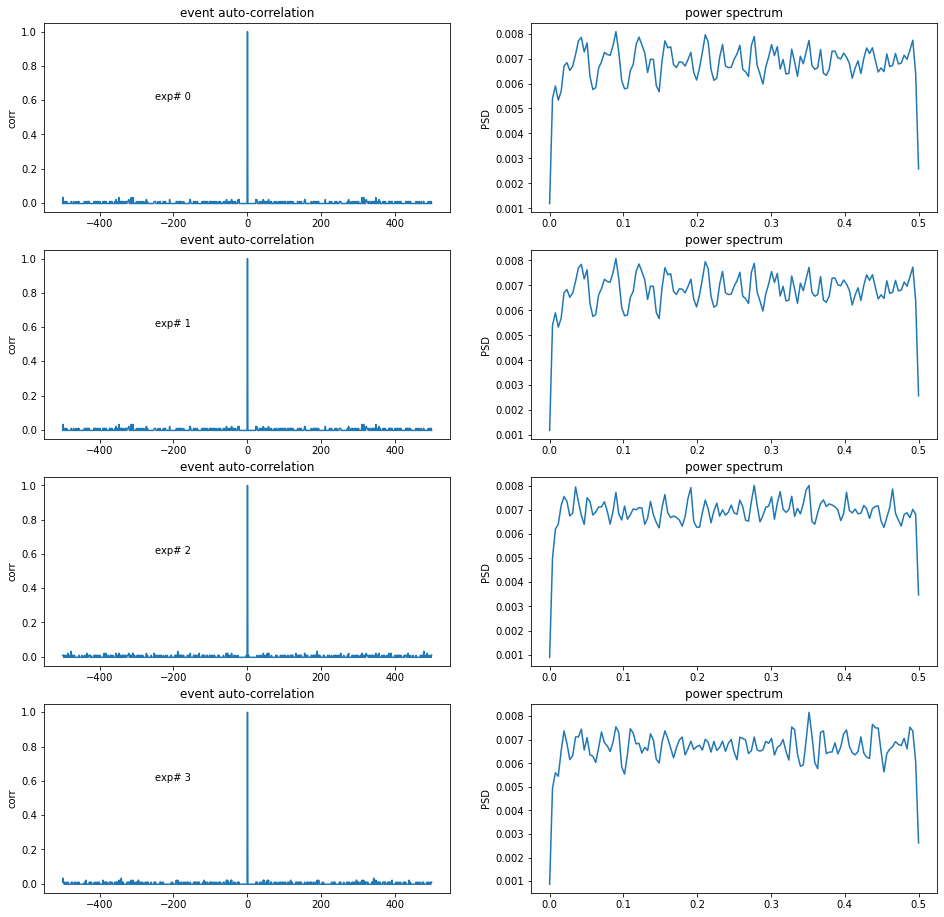

In [10]:
# take a quick look at the events
# Expect delta-fn autocorrelation and flat pwr spectrum

ns = 500               
t0 = 0
t_end = exp_length[0] #all are the same

fig, ax = plt.subplots(Nexpt,2,figsize=(16, 16))
ax = ax.flatten()
axn=0
for n in range(Nexpt):
    
    ev = behavs[n]
    print(f"\nexperiment number {n}")
    print(iei_stats(ev))
    
    # look at the
    ev_ = event_to_continuous(ev,t0,t_end,smooth=False)

    ac,lags,bl = autocorr(ev_,ns)
    #tau,er = fit_acorr_width(lags[ns:],ac[ns:])
    ax[axn].plot(lags,ac)
    ax[axn].set_title('event auto-correlation')
    ax[axn].set_ylabel('corr')
    ax[axn].text(-ns/2, .6,f"exp# {n}")

    axn += 1
    f, Pxx_den = signal.welch(ev_, 1)
    ax[axn].plot(f,Pxx_den)
    ax[axn].set_title('power spectrum')
    ax[axn].set_ylabel('PSD')
    axn +=1

In [11]:
# some correlation wrappers for getting all the "neurons" in each experiment
# most of these are just wrappers to loop over the channels

def xcorr_allneurons_with_signal(x,y,ns):
    # 
    N = x.shape[1]
    chans = x.shape[0]
    t0 = 0
    t_end = N

    Nout = 2*ns+1
    arr = np.zeros((chans, Nout), np.float32)
    narr = np.zeros(arr.shape) # truncate to same size as xcorr for now
    nstats = []
    for i in range(chans):     
        xc,lag,noise = crosscorr(x[i,:],y,ns)
        arr[i,:] = xc 
        narr[i,:] = noise[:Nout] 
        
    return arr,lag,narr


def acorr_allneurons(x,ns):
    # 
    N = x.shape[1]
    chans = x.shape[0]
    t0 = 0
    t_end = N

    Nout = 2*ns+1
    arr = np.zeros((chans, Nout), np.float32)
    narr = np.zeros(arr.shape)
    nstats = []
    for i in range(chans):     
        xc,lag,noise = crosscorr(x[i,:],x[i,:],ns)
        arr[i,:] = xc      
        narr[i,:] = noise[:Nout]
        
    return arr,lag,narr


def pwr_allneurons(x,nfft=256):
    N = x.shape[1]
    chans = x.shape[0]
    Nout = nfft//2+1
    arr = np.zeros((chans, Nout), np.float32)
    for i in range(chans):     
        f, Pxx_den = signal.welch(x[i,:], 1,nfft=nfft)
        arr[i,:] = Pxx_den
    return arr,f

def fit_acorr_width(t,y):
    def exp_func(x, a, tau, c):
        return a * np.exp(-x/tau) + c
    popt, pcov = curve_fit(exp_func, t, y)
    a,tau,c = popt
    return tau,pcov

def plot_mesh(X,Y,Z,ax,fig,txtstr,ylabstr,titlestr):  
    pcm = ax.pcolormesh(X,Y,Z)
    ax.text(5, 35, txtstr,
         #rotation=45,
         horizontalalignment='center',
         verticalalignment='top',
         multialignment='center',
           color='red', fontsize='16')
    ax.plot([0,0],[0,Z.shape[0]-1],'r-')
    ax.set_ylabel(ylabstr)
    ax.set_title(titlestr)
    fig.colorbar(pcm, ax=ax, extend='both', orientation='vertical')
    return pcm

def plot_trig_trace(x,y,ax,fig,txtstr,titlestr,cs,cbar=None): 
    # draw the 95% confidence intervals assuming 
    CI95=2.576
    if len(cs)<2:
        cs1 = cs[0]+"-"
        ci_flag=False
    else:
        cs1,cs2 = cs[0]+"-",cs[1]+":"
        ci_flag=True
        
    ax.plot(x,y,cs1)
    ax.plot([0, 0],[y.min(),y.max()],"r:")
    if ci_flag:
        ax.plot([x[0],x[-1]],[y.mean()-CI95*y.std(),y.mean()-CI95*y.std()],cs2)
        ax.plot([x[0],x[-1]],[y.mean()+CI95*y.std(),y.mean()+CI95*y.std()],cs2)
    ax.set_title(titlestr)
    ax.set_xlim([x[0],x[-1]])
    if cbar is None: 
        return
    fig.colorbar(cbar, ax=ax, extend='both', orientation='vertical')


### Neuro Signal autocorrelation and event X-correlation

This will give us a quick estimate of the structure in the signal, as well as test the relationship to the events.


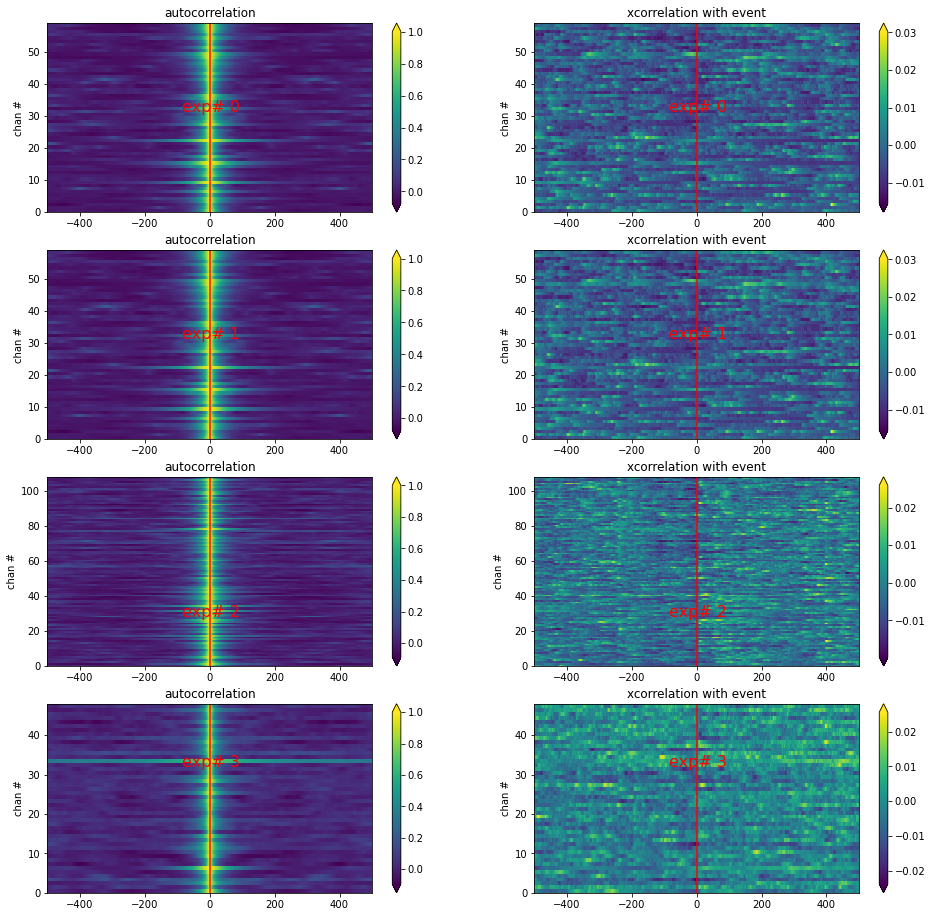

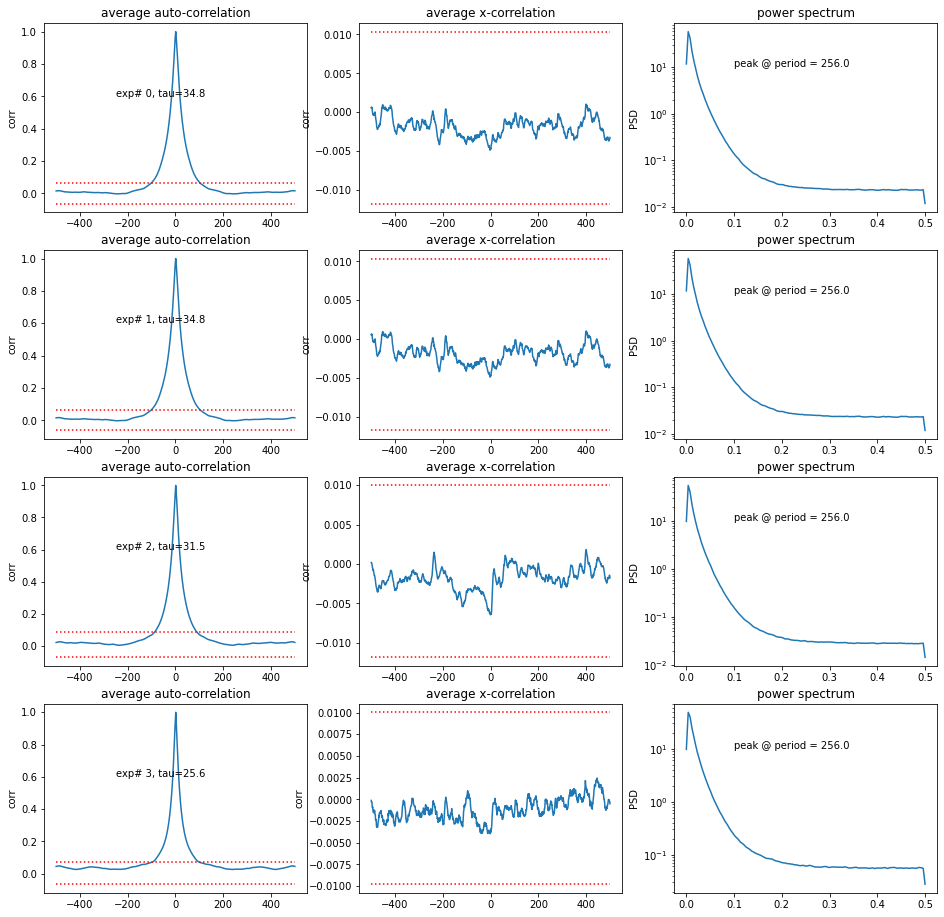

In [12]:
# loop over experiments
# get autocorrelation for each neuron and 
# cross correlation 
# TODO:  wrap this as a function to simplify OASIS analysis

fig, ax = plt.subplots(Nexpt,2,figsize=(16, 16))
ax = ax.flatten()

fig2, ax2 = plt.subplots(Nexpt,3,figsize=(16, 16))
ax2 = ax2.flatten()
axn = 0
axn2 = 0

ns = 500
nfft=256

for n in range(Nexpt):
    X = neurs[n]             
    chans = X.shape[0]
    acorr,lag,nz_ac = acorr_allneurons(X,ns)
    ac = acorr.mean(axis=0)
    tau,er = fit_acorr_width(lag[ns:],ac[ns:])

    ev = behavs[n]
    y = event_to_continuous(ev,t0,t_end,smooth=False)
    xcorr,lag,nz_xc = xcorr_allneurons_with_signal(X,y,ns)
    t_c, ch = np.meshgrid(lag,np.arange(chans))

    pwr,f = pwr_allneurons(X,nfft)
    
    # plot 1 2D
    pcm = plot_mesh(t_c,ch,acorr,ax[axn],fig,f"exp# {n}","chan #","autocorrelation")#, norm=norm, cmap='RdBu_r')
    axn += 1
    pcm = plot_mesh(t_c,ch,xcorr,ax[axn],fig,f"exp# {n}","chan #","xcorrelation with event")#, norm=norm, cmap='RdBu_r')
    axn += 1
        
    # plot #2  average over neurons
    ax2[axn2].plot(lag,acorr.mean(axis=0))
    ax2[axn2].set_title('average auto-correlation')
    ax2[axn2].set_ylabel('corr')
    ax2[axn2].text(-ns/2, .6,f"exp# {n}, tau={tau:.1f}")
    
    CI95=2.576
    y = nz_ac
    ax2[axn2].plot([lag[0],lag[-1]],[y.mean()-CI95*y.std(),y.mean()-CI95*y.std()],'r:')
    ax2[axn2].plot([lag[0],lag[-1]],[y.mean()+CI95*y.std(),y.mean()+CI95*y.std()],'r:')
    axn2 += 1
    ax2[axn2].plot(lag,xcorr.mean(axis=0))
    ax2[axn2].set_title('average x-correlation')
    ax2[axn2].set_ylabel('corr')
    y = nz_xc
    ax2[axn2].plot([lag[0],lag[-1]],[y.mean()-CI95*y.std(),y.mean()-CI95*y.std()],'r:')
    ax2[axn2].plot([lag[0],lag[-1]],[y.mean()+CI95*y.std(),y.mean()+CI95*y.std()],'r:')
    axn2 += 1
    # get the average spectrum
    peak_period = 1/f[np.argmax(pwr.mean(axis=0))]
    ax2[axn2].plot(f,pwr.mean(axis=0))
    ax2[axn2].set_title('power spectrum')
    ax2[axn2].text(.1,10,f'peak @ period = {peak_period}')
    
    ax2[axn2].set_ylabel('PSD')
    ax2[axn2].set_yscale("log")
    axn2 +=1
    
    
    

# RESULT - 0.2:  
## Signal and Event timescales - autocorrelation

The autocorrelation in the calcium neural signal is very strong as expected.  The timescale is related to the decay of the flourecence.   

Unfortunately the signal to noise (S/N) was low for the cross-correlation between the events and the neural signal, and its not clear if there is a consistent relationship.  Though so far I haven't looked closely at infividual neural signals, as averaging across non-related signals could be masking a true assoiciation.  Also, there's no reason to assume that the phase/sign of the event related response are typical across the neurons.  

The cross correlation may be blurring the event-locked signal, given how strong the autocorration is.  I have a two-fold strategy to ameliorate this difficulty:  1) a peri-event time average, and 2) deconvolving the Ca-signal with a model-based approach to infer the underlying neural activity in the Ca-signal.


## Behavioral Event STATS
As evident in the spectrum and autocorrelation (and expected) there is no discernible structure in the behavioral events, although the sequence happens to be identical between the first two experiments. 

In [13]:
behavs

[array([  176,   292,   472,   529,   566,   618,   721,  1031,  2340,
         2582,  2989,  3174,  3674,  4529,  5840,  5884,  5996,  6270,
         6494,  6592,  7365,  7688,  7939,  8264,  8931,  9153,  9273,
         9331,  9364,  9647,  9679,  9802, 10218, 10375, 10401, 10723,
        10832, 11363, 11950, 11996, 12306, 12709, 13298, 13349, 14312,
        14603, 14700, 15160, 15233, 15461, 15504, 15939, 16162, 16225,
        16477, 16502, 16833, 17021, 17044, 17086, 17163, 17336, 17660,
        17684, 17707, 18044, 18099, 18184, 18713, 19588, 19909, 19934,
        20266, 21240, 22357, 22436, 22493, 22536, 22847, 23539, 23693,
        23732, 23849, 24232, 24599, 24967]),
 array([  176,   292,   472,   529,   566,   618,   721,  1031,  2340,
         2582,  2989,  3174,  3674,  4529,  5840,  5884,  5996,  6270,
         6494,  6592,  7365,  7688,  7939,  8264,  8931,  9153,  9273,
         9331,  9364,  9647,  9679,  9802, 10218, 10375, 10401, 10723,
        10832, 11363, 11950, 119

# 1 - FIRST PASS ANALYSIS:  Peri-Event Signal


Assumptions: 
- I will need to include negative lag-times in the peri-event averages because I don't know if the behaviors are leading or lagging.  (Where in the brain are the recording made?  i.e. Could be motor or sensory)

- In order to assess an event locked signal eventually I need to develop some baseline statistics and a develop statistical threshold.

- An experimental trial-shifted control level would be great, but since there may be some structure to the behavior timing I will also want some other "surrogate" measures for baselines.



In [14]:
# define some analysis functions

def get_all_channels_peri_event(X, t_event, times):    
    chan = X.shape[0]
    M = times.shape[0]
    arr = np.zeros((chan,M), np.float32)
    
    x_i = times+t_event
    # mask just incase we go out of bounds
    x_m = (x_i >0) & (x_i<X.shape[1])
    arr[:,x_m] = X[:,x_i[x_m]] 
    return arr

def get_event_triggered_array(events, xs, times):
    N = events.shape[0]
    M = times.shape[0]
    chans = xs.shape[0]
    
    arr = np.zeros((N,chans, M), np.float32)
    for i in range(N):   
        t_event = events[i]
        eta = get_all_channels_peri_event(X, t_event, times)  
        arr[i,:,:] = eta 
    return arr


def random_surrogate_IEImatched(ev,t0,t_end):
    # match the ieis. 
    # Should be ~ Poisson accounts for some additional structure in IEIs 
    iei = np.diff(ev)
    
    surrogate = np.cumsum(np.random.permutation(iei))
    # need to an additional event. 
    # place it randomly somewhere before the first one or after the last one... 
    # pick with uniform prob .
    extra = np.random.randint(t0,surrogate[0]+(t_end-surrogate[-1]),1)
    if extra < surrogate[0]: #add to the beginning
        t_event = extra
        surrogate = np.append(t_event,surrogate)    
    else:  #add to the end.
        t_event = extra+surrogate[-1]-surrogate[0]
        surrogate = np.append(surrogate,t_event)
        
    return surrogate

def random_surrogate_Poisson(Nev,t0,t_end):
    # uniformly spread events (rate matched poisson) 
    # could be collisions... but rare
    return np.sort(np.random.randint(t0,t_end,Nev))



In [15]:
#### some visualization helpers.
# wrap a pcolormesh and STA plotter

def plot_trig_trace(x,y,ax,fig,txtstr,titlestr,cs,cbar=None): 
    # draw the 95% confidence intervals assuming 
    CI95=2.576
    if len(cs)<2:
        cs1 = cs[0]+"-"
        ci_flag=False
    else:
        cs1,cs2 = cs[0]+"-",cs[1]+":"
        ci_flag=True
        
    ax.plot(x,y,cs1)
    ax.plot([0, 0],[y.min(),y.max()],"r:")
    if ci_flag:
        ax.plot([x[0],x[-1]],[y.mean()-CI95*y.std(),y.mean()-CI95*y.std()],cs2)
        ax.plot([x[0],x[-1]],[y.mean()+CI95*y.std(),y.mean()+CI95*y.std()],cs2)
    ax.set_title(titlestr)
    ax.set_xlim([x[0],x[-1]])
    if cbar is None: 
        return
    fig.colorbar(cbar, ax=ax, extend='both', orientation='vertical')

def plot_event_triggered_plus_surrogates(exp_n,times,trig_resp,surrogate_1,surrogate_2,surrogate_3):
    # infer sizes
    Nev = trig_resp.shape[0]
    chans = trig_resp.shape[1]

    fig, ax = plt.subplots(5,2,figsize=(16, 16))
    ax = ax.flatten()

    
    ev_trig_mu = trig_resp.mean(axis=0)
    ev_trig_vr = trig_resp.var(axis=0)

    t_c, ch = np.meshgrid(times,np.arange(chans))
    t_e, ev = np.meshgrid(times,np.arange(Nev))


    ########  Surrogate experiment trial-shifted
    ev_trig_mu3 = surrogate_3.mean(axis=0)
    ev_trig_vr3 = surrogate_3.var(axis=0)

    ########  Surrogates #2 IEI matched & #1 random 
    ev_trig_mu1 = surrogate_1.mean(axis=0)
    ev_trig_vr1 = surrogate_1.var(axis=0)
    ev_trig_mu2 = surrogate_2.mean(axis=0)
    ev_trig_vr2 = surrogate_2.var(axis=0)

    ev_trig_vr_e = trig_resp.var(axis=1)
    ########  Surrogate experiment trial-shifted
    ev_trig_vr3_e = surrogate_3.var(axis=1)

    
    # signal
    axn = 0
    pcm = plot_mesh(t_c,ch,ev_trig_mu,ax[axn],fig,f"exp# {exp_n}","chan #","signal mean") 
    axn += 1
    plot_mesh(t_c,ch,ev_trig_vr,ax[axn],fig,f"exp# {exp_n}","chan #","signal variance") 

    # surrogate 1
    axn +=1
    plot_mesh(t_c,ch,ev_trig_mu1,ax[axn],fig,f"random","chan #","signal mean") 
    axn += 1
    plot_mesh(t_c,ch,ev_trig_vr1,ax[axn],fig,f"random","chan #","signal variance") 

    # surrogate 2
    axn +=1
    plot_mesh(t_c,ch,ev_trig_mu2,ax[axn],fig,f"random(iei)","chan #","signal mean") 
    axn += 1
    plot_mesh(t_c,ch,ev_trig_vr2,ax[axn],fig,f"random(iei)","chan #","signal variance") 

    # surrogate 3
    axn +=1
    plot_mesh(t_c,ch,ev_trig_mu3,ax[axn],fig,f"trial-shifted","chan #","signal mean") 
    axn += 1
    plot_mesh(t_c,ch,ev_trig_vr3,ax[axn],fig,f"trial-shifted","chan #","signal variance") 


    # collaps over neurons and keep each event
    axn +=1
    plot_mesh(t_e,ev,ev_trig_vr_e,ax[axn],fig,f"exp# {exp_n}","event #","signal variance") 
    axn += 1
    plot_mesh(t_e,ev,ev_trig_vr3_e,ax[axn],fig,f"trial-shifted","event #","signal variance") 
    
    plt.show()
    fig.savefig(f'triggered_resp_summary_expt{exp_n}.png', dpi=150)
    
    
    
def plot_simple_summary(exp_n,times,trig_resp,surrogate_1,surrogate_2,surrogate_3,zoom=[]):

    Nev = trig_resp.shape[0]
    chans = trig_resp.shape[1]

    zoom_in = len(zoom)>0
    
    fig, ax = plt.subplots(2,2,figsize=(16, 8))
    ax = ax.flatten()

    ev_trig_mu = trig_resp.mean(axis=0)

    t_c, ch = np.meshgrid(times,np.arange(chans))

    
    ########  Surrogate experiment trial-shifted
    ev_trig_mu3 = surrogate_3.mean(axis=0)

    ########  Surrogates #2 IEI matched & #1 random 
    ev_trig_mu1 = surrogate_1.mean(axis=0)
    ev_trig_mu2 = surrogate_2.mean(axis=0)
    
    # signal
    axn = 0
    pcm = plot_mesh(t_c,ch,ev_trig_mu,ax[axn],fig,f"exp# {exp_n}","chan #","signal mean") 
    if zoom_in:
        ax[axn].set_xlim(zoom)

    # noise estimate (just show one)
    axn +=1
    plot_mesh(t_c,ch,ev_trig_mu1,ax[axn],fig,f"random","chan #","signal mean") 
    if zoom_in:
        ax[axn].set_xlim(zoom)
    #     axn +=1
    #     plot_mesh(t_c,ch,ev_trig_mu2,ax[axn],fig,f"random(iei)","chan #","signal mean") 
    #     axn +=1
    #     plot_mesh(t_c,ch,ev_trig_mu3,ax[axn],fig,f"trial-shifted","chan #","signal mean") 


    # now plot the traces... real event triggered average across aray as w
    mu_ = ev_trig_mu.mean(axis=0)
    mu_s1 = ev_trig_mu1.mean(axis=0)
    mu_s2 = ev_trig_mu2.mean(axis=0)
    mu_s3 = ev_trig_mu3.mean(axis=0)
    
    axn += 1
    plot_trig_trace(times,mu_,ax[axn],fig,f"exp# {exp_n}","avg signal ","kr")
    plot_trig_trace(times,mu_s1,ax[axn],fig,"","avg signal","gc",cbar=pcm)
    if zoom_in:
        ax[axn].set_xlim(zoom)
    #     axn += 1
    #     plot_trig_trace(times,mu_,ax[axn],fig,f"exp# {exp_n}","avg signal ","k")
    #     plot_trig_trace(times,mu_s2,ax[axn],fig,"","avg signal","bc",cbar=pcm)
    #     axn += 1
    #     plot_trig_trace(times,mu_,ax[axn],fig,f"exp# {exp_n}","avg signal ","k")
    #     plot_trig_trace(times,mu_s3,ax[axn],fig,"","avg signal","yc",cbar=pcm)

    axn += 1
    plot_trig_trace(times,mu_s1,ax[axn],fig,"","avg signal","gy")
    plot_trig_trace(times,mu_s2,ax[axn],fig,"","avg signal","by")
    plot_trig_trace(times,mu_s3,ax[axn],fig,"","avg signal","yy")
    plot_trig_trace(times,mu_,ax[axn],fig,f"exp# {exp_n}","avg signal ","kr",cbar=pcm)
    if zoom_in:
        ax[axn].set_xlim(zoom)

    
    plt.show()
    fig.savefig(f'triggered_resp_simple_DeconvSummary_expt{exp_n}.png', dpi=150)
    
        
def plot_simple_summary_squared_resp(exp_n,times,trig_resp,surrogate_1,surrogate_2,surrogate_3,zoom=[]):

    Nev = trig_resp.shape[0]
    chans = trig_resp.shape[1]

    zoom_in = len(zoom)>0
    
    fig, ax = plt.subplots(2,2,figsize=(16, 8))
    ax = ax.flatten()

    ev_trig_mu = trig_resp.mean(axis=0)

    t_c, ch = np.meshgrid(times,np.arange(chans))

    
    ########  Surrogate experiment trial-shifted
    ev_trig_mu3 = surrogate_3.mean(axis=0)

    ########  Surrogates #2 IEI matched & #1 random 
    ev_trig_mu1 = surrogate_1.mean(axis=0)
    ev_trig_mu2 = surrogate_2.mean(axis=0)
    
    # square the quantities 
    ev_trig_mu = np.square(ev_trig_mu)
    ev_trig_mu1 = np.square(ev_trig_mu1)
    ev_trig_mu2 = np.square(ev_trig_mu2)
    ev_trig_mu3 = np.square(ev_trig_mu3)
    
    # signal
    axn = 0
    pcm = plot_mesh(t_c,ch,ev_trig_mu,ax[axn],fig,f"exp# {exp_n}","chan #","sq signal mean") 
    if zoom_in:
        ax[axn].set_xlim(zoom)

    # noise estimate (just show one)
    axn +=1
    plot_mesh(t_c,ch,ev_trig_mu1,ax[axn],fig,f"random","chan #","sq signal mean") 
    if zoom_in:
        ax[axn].set_xlim(zoom)

    # now plot the traces... real event triggered average across aray as w
    mu_ = ev_trig_mu.mean(axis=0)
    mu_s1 = ev_trig_mu1.mean(axis=0)
    mu_s2 = ev_trig_mu2.mean(axis=0)
    mu_s3 = ev_trig_mu3.mean(axis=0)
    
    axn += 1
    plot_trig_trace(times,mu_,ax[axn],fig,f"exp# {exp_n}","avg signal sq ","kr")
    plot_trig_trace(times,mu_s1,ax[axn],fig,"","avg signal sq","gc",cbar=pcm)
    if zoom_in:
        ax[axn].set_xlim(zoom)

    axn += 1
    plot_trig_trace(times,mu_s1,ax[axn],fig,"","avg signal sq","gy")
    plot_trig_trace(times,mu_s2,ax[axn],fig,"","avg signal sq","by")
    plot_trig_trace(times,mu_s3,ax[axn],fig,"","avg signal sq","yy")
    plot_trig_trace(times,mu_,ax[axn],fig,f"exp# {exp_n}","avg signal sq","kr",cbar=pcm)
    if zoom_in:
        ax[axn].set_xlim(zoom)

    
    plt.show()
    fig.savefig(f'triggered_resp_simple_DeconvSummary_expt{exp_n}.png', dpi=150)
    


experiment number 0
	avg event period = 2.916588e+02 (min,max=(23, 1311)) over N=86 events, cv=1.0042


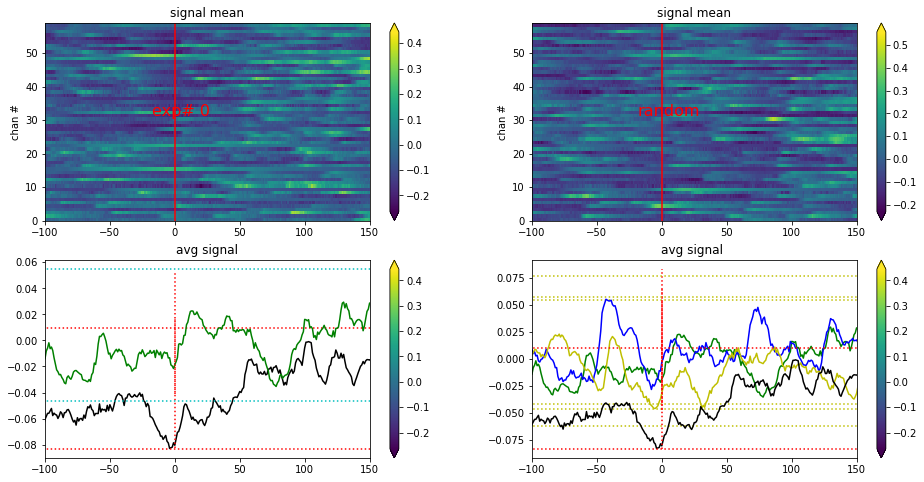


experiment number 1
	avg event period = 2.916588e+02 (min,max=(23, 1311)) over N=86 events, cv=1.0042


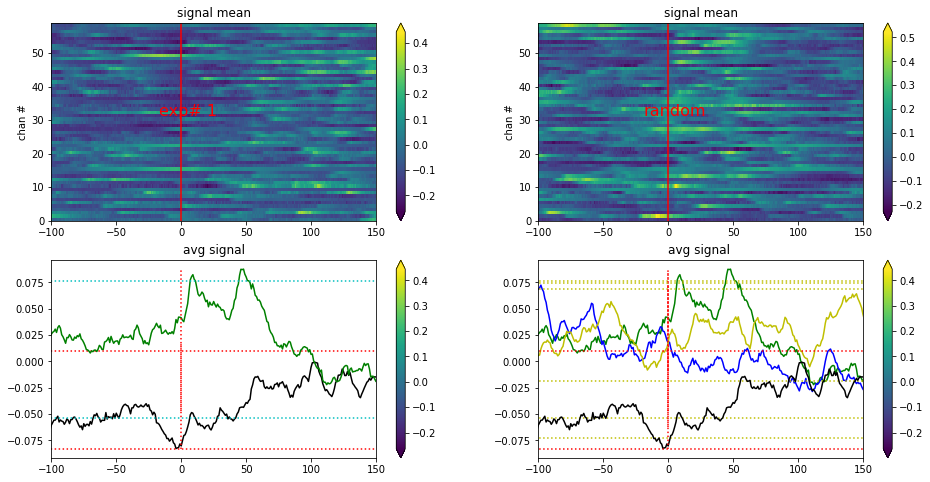


experiment number 2
	avg event period = 2.843412e+02 (min,max=(3, 1311)) over N=86 events, cv=0.9853


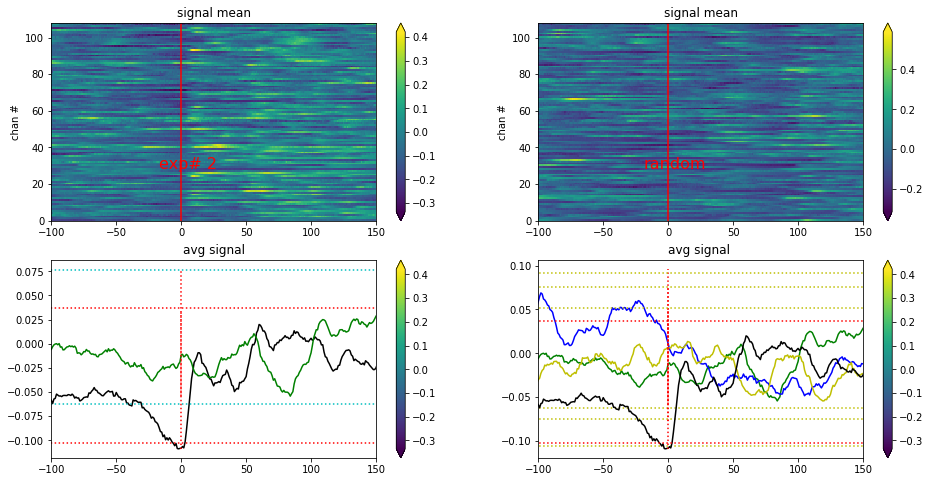


experiment number 3
	avg event period = 2.920118e+02 (min,max=(23, 1355)) over N=86 events, cv=1.0265


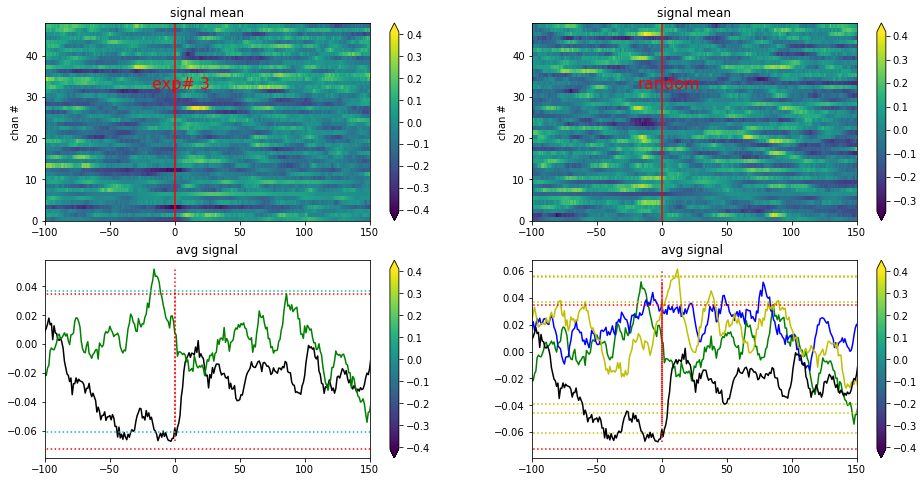

In [16]:
##################
# TODO: wrap this as a function for re-use in OASIS analysis

expt_n = np.arange(Nexpt)

# for trial-shifted surrogate
expt_n_ = np.roll(expt_n,2)

#time samples before and after event to collect
t_pre,t_post = (200,400)
times = np.arange(-t_pre,t_post)

# find overall correlation

for exp_n in expt_n:
    X = neurs[exp_n]
    events = behavs[exp_n]

    Nev = ev.shape[0]
    chans = X.shape[0]
    t_end = X.shape[1]
    t0 = 0
    print(f"\nexperiment number {exp_n}")
    print(iei_stats(events))

    trig_resp = get_event_triggered_array(events,X,times)

    # create an experiment shifted surrogate
    events_shift = behavs[expt_n_[exp_n]]
    surrogate_3 = get_event_triggered_array(events_shift,X,times)
    exp_n_ = expt_n_[exp_n]

    print
    
    # tetst some other "surrogates" in case the experimental trials give the events a regularity
    events_s1 = random_surrogate_Poisson(Nev,t0,t_end)
    surrogate_1 = get_event_triggered_array(events_s1,X,times)

    events_s2 = random_surrogate_IEImatched(events,t0,t_end)
    surrogate_2 = get_event_triggered_array(events_s2,X,times)

    #plot_event_triggered_plus_surrogates(exp_n,times,trig_resp,surrogate_1,surrogate_2,surrogate_3)
    plot_simple_summary(exp_n,times,trig_resp,surrogate_1,surrogate_2,surrogate_3,zoom=[-100,150])


# RESULT - 1.0:  
## Peri-Event responses

As feared the peri-event averages are not conclusive.  The Ca DeltaF/F transients are large and decay slowly.  However, there seems to be some structure right aorund time zero.   
Deconvolving the large DeltaF/F signal into infered spikes should help.  




# 2. DEEPER-DIVE: OASIS deconvolution of Ca signal
    - deconvolve the calcium flourescnce signal to increas signal to Noise
    - refined results?

## OASIS 
Oasis is a tool for extracting the neural activity from fluorescence calcium imaging data &ensp.  It deconvolves the raw $\delta_F/F$ signal to infer spikes, baseline signal, and noise sources.  Code is available at 'https://travis-ci.org/j-friedrich/OASIS', and is built into the CaImAn suite. 
REFERENCE: Friedrich J, Zhou P, Paninski L. [Fast Online Deconvolution of Calcium Imaging Data.](http://dx.doi.org/10.1371/journal.pcbi.1005423) PLoS Comput Biol. 2017; 13(3):e1005423.


It works reasonably well out-of-the-box.  This snip from the demo on our data indicates it works pretty well.  

CPU times: user 302 ms, sys: 3.67 ms, total: 306 ms
Wall time: 52.3 ms
Correlation of denoised fluorescence with ground truth ('calcium'): 0.8486


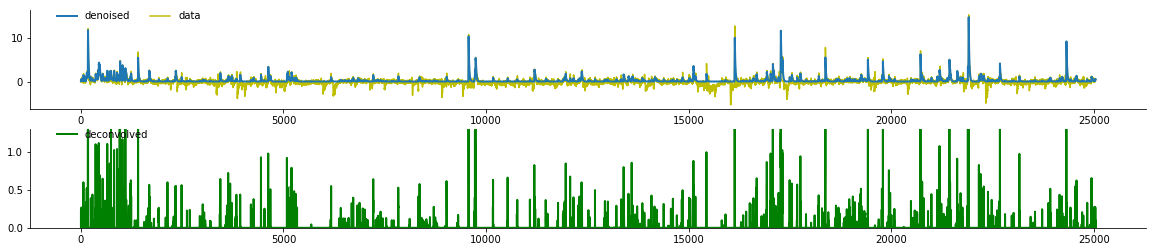

In [17]:
# expository code from OASIS demo

def plot_trace(groundtruth=False):
    plt.figure(figsize=(20,4))
    plt.subplot(211)
    plt.plot(b+c, lw=2, label='denoised')
    if groundtruth:
        plt.plot(true_b+true_c, c='r', label='truth', zorder=-11)
    plt.plot(y, label='data', zorder=-12, c='y')
    plt.legend(ncol=3, frameon=False, loc=(.02,.85))
    simpleaxis(plt.gca())
    plt.subplot(212)
    plt.plot(s, lw=2, label='deconvolved', c='g')
    if groundtruth:
        for k in np.where(true_s)[0]:
            plt.plot([k,k],[-.1,1], c='r', zorder=-11, clip_on=False)
    plt.ylim(0,1.3)
    plt.legend(ncol=3, frameon=False, loc=(.02,.85));
    simpleaxis(plt.gca())
    #print("Correlation of deconvolved activity  with ground truth ('spikes') : %.4f" % np.corrcoef(s,true_s)[0,1])
    print("Correlation of denoised fluorescence with ground truth ('calcium'): %.4f" % np.corrcoef(c,true_c)[0,1])


# no optimization of g
y = X[1,:]
%time c, s, b, g, lam = deconvolve(y, penalty=0)
true_c = y
# the line below uses the direct autocorrelation estimate without fudge_factor, yielding worse results
plot_trace()



The simple call:  `deconvolve(y, penalty=1)`  seems good enough for a first pass analysis and is fast!!

CPU times: user 76.6 ms, sys: 2.04 ms, total: 78.6 ms
Wall time: 12.9 ms
Correlation of denoised fluorescence with ground truth ('calcium'): 0.8486
CPU times: user 589 ms, sys: 5.75 ms, total: 594 ms
Wall time: 99.3 ms
Correlation of denoised fluorescence with ground truth ('calcium'): 0.8624


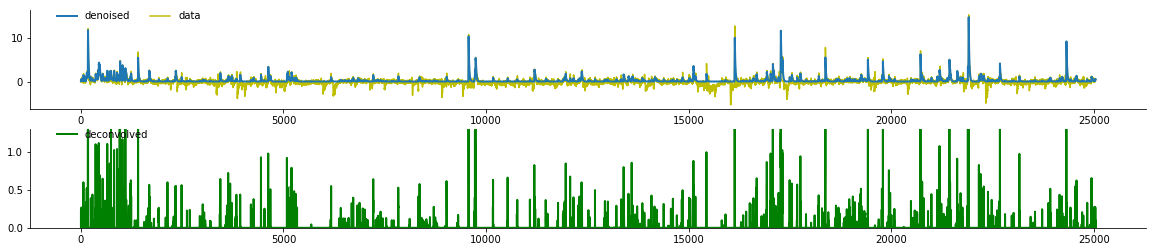

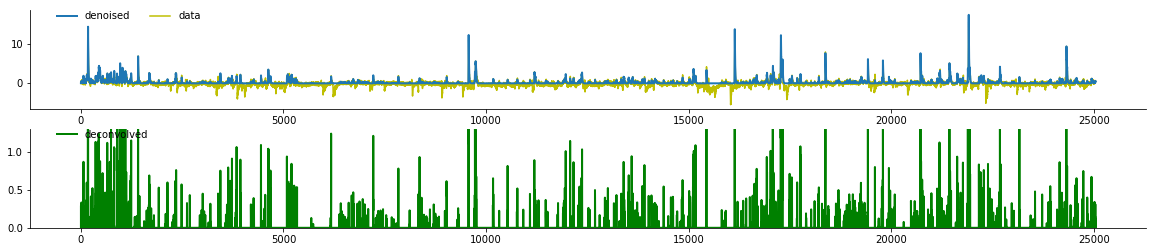

In [18]:
y=X[1,:]

%time c, s, b, g, lam = deconvolve(y, penalty=1)

#     c : array, shape (T,)
#         The inferred denoised fluorescence signal at each time-bin.
#     s : array, shape (T,)
#         Discretized deconvolved neural activity (spikes).
#     b : float
#         Fluorescence baseline value.
#     g : tuple of float
#         Parameters of the AR(2) process that models the fluorescence impulse response.
#     lam: float
#         Optimal Lagrange multiplier for noise constraint under L1 penalty

plot_trace()
# optimization of g. optimize_g=5 uses 5 large isolated calcium events to update g.
%time c, s, b, g, lam = deconvolve(y, penalty=0, optimize_g=5)
plot_trace()

In [19]:
# make a wrapper to apply the deconvolution to each expt data set

def deconvolve_experiment(X):
    chan = X.shape[0]
    # optimization of g. optimize_g=5 uses 5 large isolated calcium events to update g. but slower
    # c, s, b, g, lam = deconvolve(y, penalty=0, optimize_g=5)
    s_arr = np.zeros(X.shape)
    for ch in range(chan):
        #c, s, b, g, lam = deconvolve(y, penalty=1)
        _, s, _, _, _ = deconvolve(X[ch,:], penalty=1)
        s_arr[ch,:]=s
        
    return s_arr
    
    

    

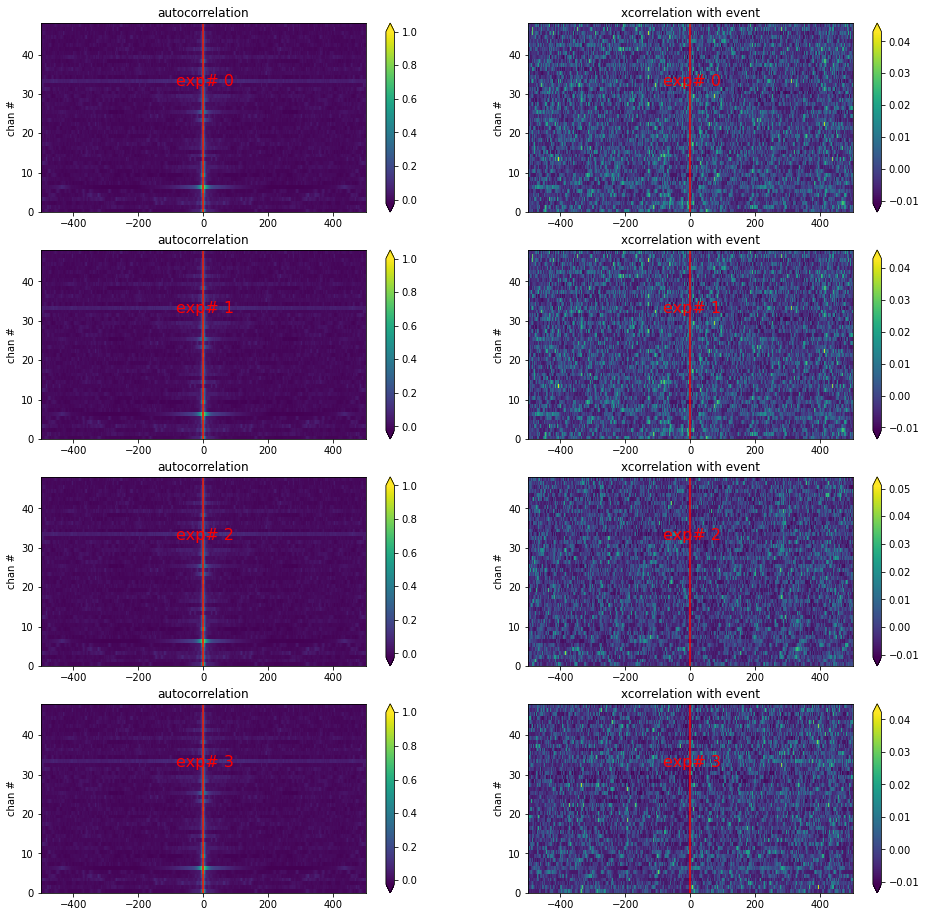

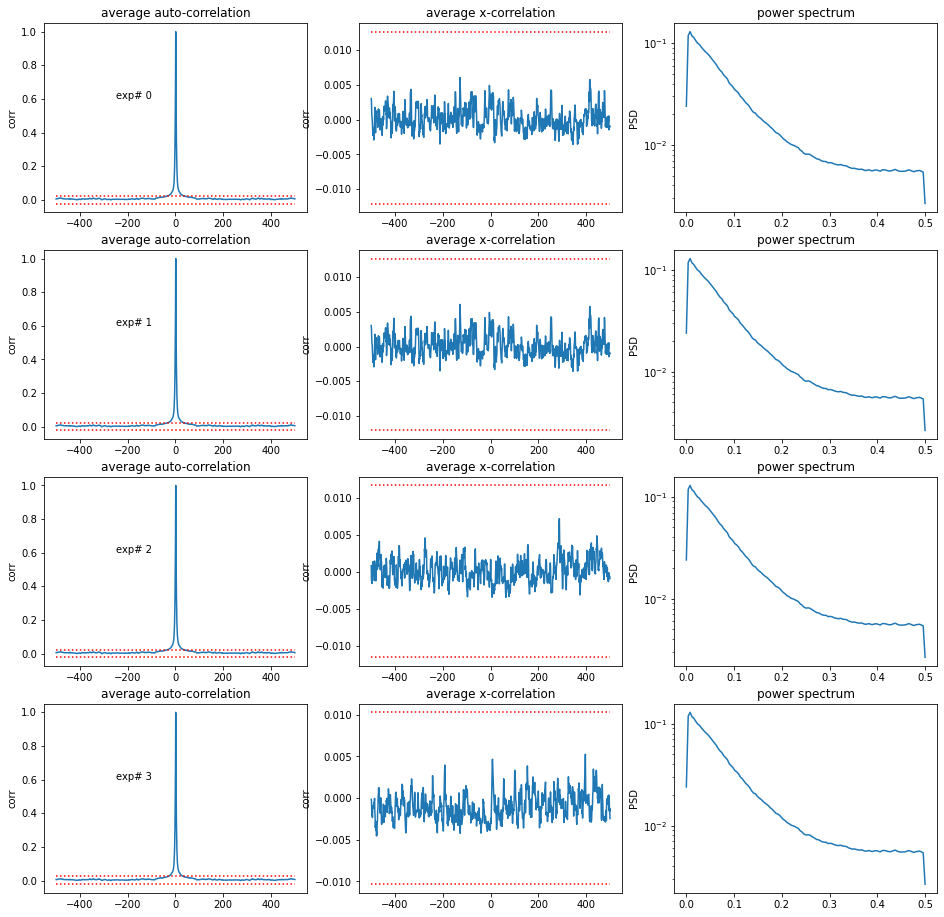

In [20]:

fig, ax = plt.subplots(Nexpt,2,figsize=(16, 16))
ax = ax.flatten()

fig2, ax2 = plt.subplots(Nexpt,3,figsize=(16, 16))
ax2 = ax2.flatten()
axn = 0
axn2 = 0

ns = 500

neurs_deconv = []

file_name = os.path.join(interim_data,"expt_deconv.pkl")    
    
for n in range(Nexpt):
    
    Xraw = neurs[exp_n]
    X = deconvolve_experiment(Xraw)
    # save the deconvolved data for further analysis. Also pkl?
    neurs_deconv.append(X)
    
    chans = X.shape[0]
    acorr,lag,nz_ac = acorr_allneurons(X,ns)
    
    ev = behavs[n]
    y = event_to_continuous(ev,t0,t_end,smooth=False)
    xcorr,lag,nz_xc = xcorr_allneurons_with_signal(X,y,ns)

    nfft=256
    pwr,f = pwr_allneurons(X,nfft)

    t_c, ch = np.meshgrid(lag,np.arange(chans))

    # plot 1 2D
    pcm = plot_mesh(t_c,ch,acorr,ax[axn],fig,f"exp# {n}","chan #","autocorrelation")#, norm=norm, cmap='RdBu_r')
    axn += 1
    pcm = plot_mesh(t_c,ch,xcorr,ax[axn],fig,f"exp# {n}","chan #","xcorrelation with event")#, norm=norm, cmap='RdBu_r')
    axn += 1
        
    # plot #2  average over neurons
    ax2[axn2].plot(lag,acorr.mean(axis=0))
    ax2[axn2].set_title('average auto-correlation')
    ax2[axn2].set_ylabel('corr')
    ax2[axn2].text(-ns/2, .6,f"exp# {n}")
    CI95=2.576
    y = nz_ac
    ax2[axn2].plot([lag[0],lag[-1]],[y.mean()-CI95*y.std(),y.mean()-CI95*y.std()],'r:')
    ax2[axn2].plot([lag[0],lag[-1]],[y.mean()+CI95*y.std(),y.mean()+CI95*y.std()],'r:')
    axn2 += 1
    
    
    ax2[axn2].plot(lag,xcorr.mean(axis=0))
    ax2[axn2].set_title('average x-correlation')
    ax2[axn2].set_ylabel('corr')
    y = nz_xc
    ax2[axn2].plot([lag[0],lag[-1]],[y.mean()-CI95*y.std(),y.mean()-CI95*y.std()],'r:')
    ax2[axn2].plot([lag[0],lag[-1]],[y.mean()+CI95*y.std(),y.mean()+CI95*y.std()],'r:')
    axn2 += 1
    
    # get the average spectrum
    ax2[axn2].plot(f,pwr.mean(axis=0))
    ax2[axn2].set_title('power spectrum')
    ax2[axn2].set_ylabel('PSD')
    ax2[axn2].set_yscale("log")
    axn2 +=1
    

    
expt_deconv = (neurs_deconv,behavs,summaries)
#file_name = os.path.join(interim_data,"expt.pkl")
with open(file_name, "wb") as f:
    pickle.dump(expt, f)



experiment number 0
	avg event period = 2.916588e+02 (min,max=(23, 1311)) over N=86 events, cv=1.0042


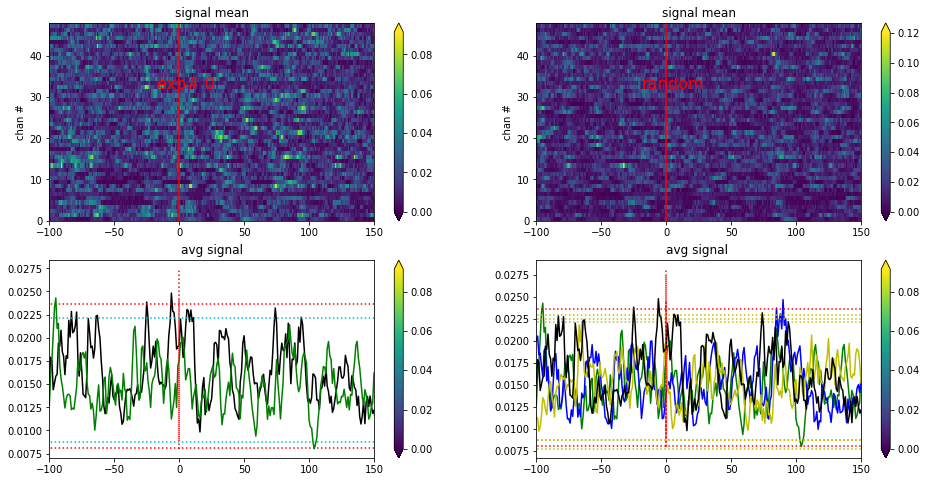


experiment number 1
	avg event period = 2.916588e+02 (min,max=(23, 1311)) over N=86 events, cv=1.0042


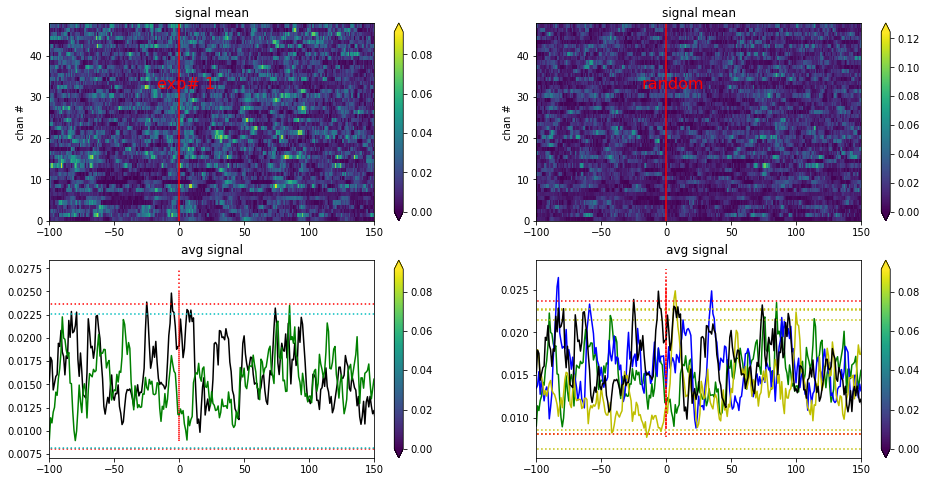


experiment number 2
	avg event period = 2.843412e+02 (min,max=(3, 1311)) over N=86 events, cv=0.9853


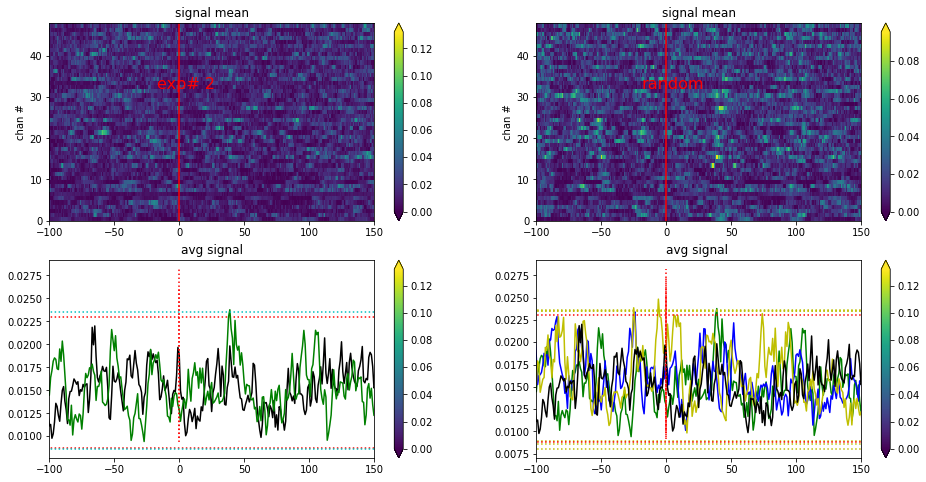


experiment number 3
	avg event period = 2.920118e+02 (min,max=(23, 1355)) over N=86 events, cv=1.0265


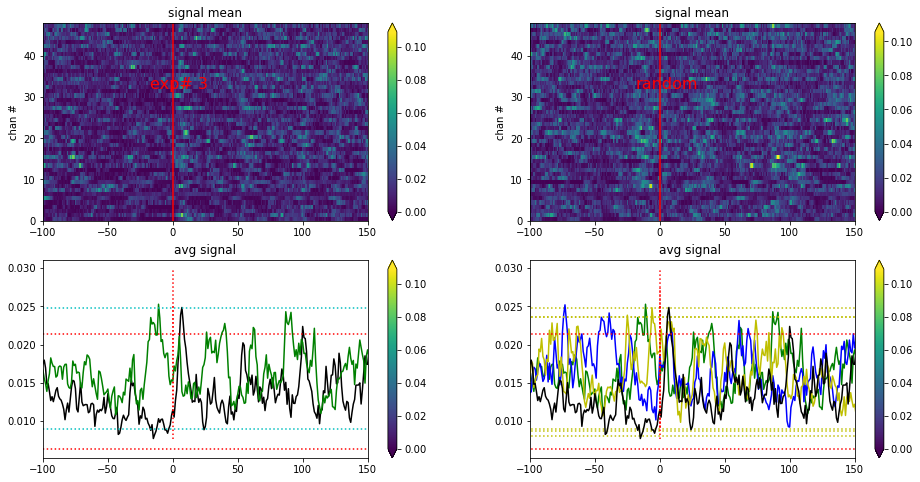

In [21]:

##################
# TODO: replace wiht a function

expt_n = np.arange(Nexpt)

# for trial-shifted surrogate
expt_n_ = np.roll(expt_n,2)

#time samples before and after event to collect
t_pre,t_post = (200,400)
times = np.arange(-t_pre,t_post)

# find overall correlation

for exp_n in expt_n:    
    #     Xraw = neurs[exp_n]
    #     X = deconvolve_experiment(Xraw)
    
    X = neurs_deconv[exp_n]

    events = behavs[exp_n]

    Nev = ev.shape[0]
    chans = X.shape[0]
    t_end = X.shape[1]
    t0 = 0
    print(f"\nexperiment number {exp_n}")
    print(iei_stats(events))

    trig_resp = get_event_triggered_array(events,X,times)

    # create an experiment shifted surrogate
    events_shift = behavs[expt_n_[exp_n]]
    surrogate_3 = get_event_triggered_array(events_shift,X,times)
    exp_n_ = expt_n_[exp_n]

    print
    
    # tetst some other "surrogates" in case the experimental trials give the events a regularity
    events_s1 = random_surrogate_Poisson(Nev,t0,t_end)
    surrogate_1 = get_event_triggered_array(events_s1,X,times)

    events_s2 = random_surrogate_IEImatched(events,t0,t_end)
    surrogate_2 = get_event_triggered_array(events_s2,X,times)

    #plot_event_triggered_plus_surrogates(exp_n,times,trig_resp,surrogate_1,surrogate_2,surrogate_3)
    plot_simple_summary(exp_n,times,trig_resp,surrogate_1,surrogate_2,surrogate_3,zoom=[-100,150])



# RESULT - 2.0:  
## OASIS peri-stimulus and cross-correlation results
Unfortunately the devonvolution did not make population average results clear. However, the deconvolution made things more consistent as expected due to the amelioration of the large events. 

For a last check, I will look at the average "power" across the channels in the event triggered averages.  This should discount low S/N channels, and polarity issues.


experiment number 0
	avg event period = 2.916588e+02 (min,max=(23, 1311)) over N=86 events, cv=1.0042


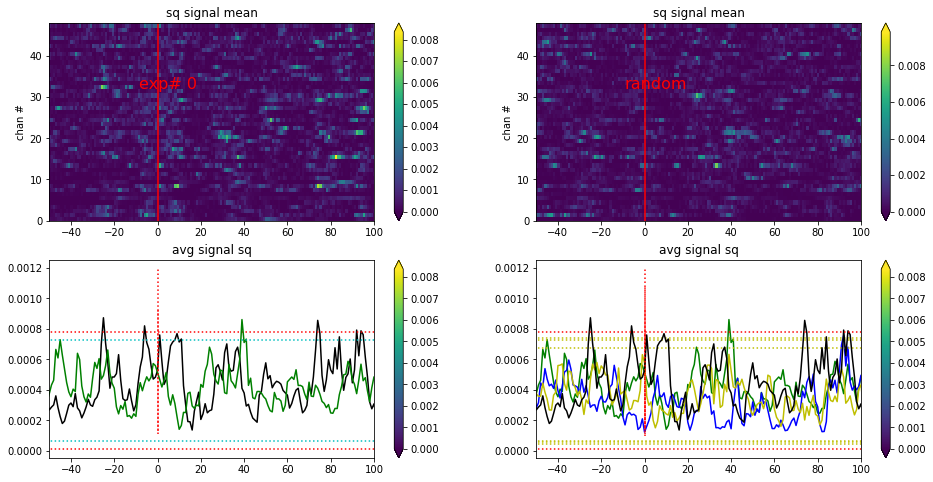


experiment number 1
	avg event period = 2.916588e+02 (min,max=(23, 1311)) over N=86 events, cv=1.0042


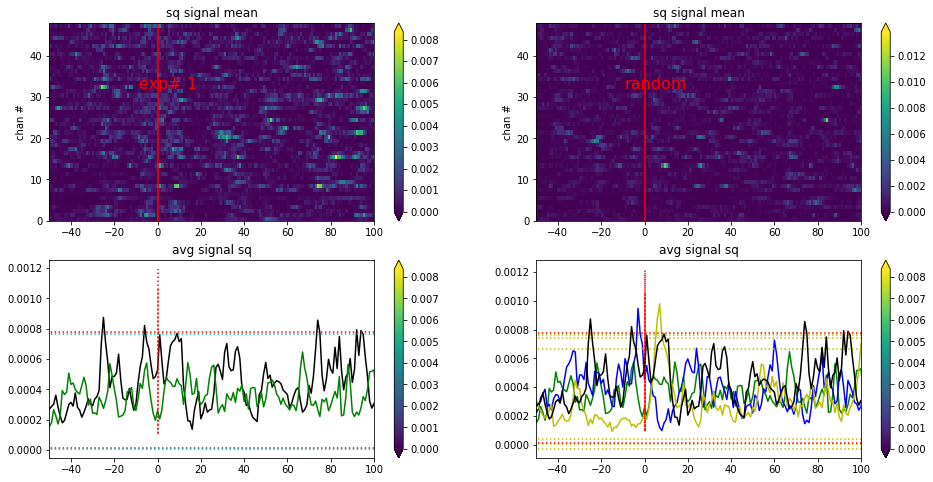


experiment number 2
	avg event period = 2.843412e+02 (min,max=(3, 1311)) over N=86 events, cv=0.9853


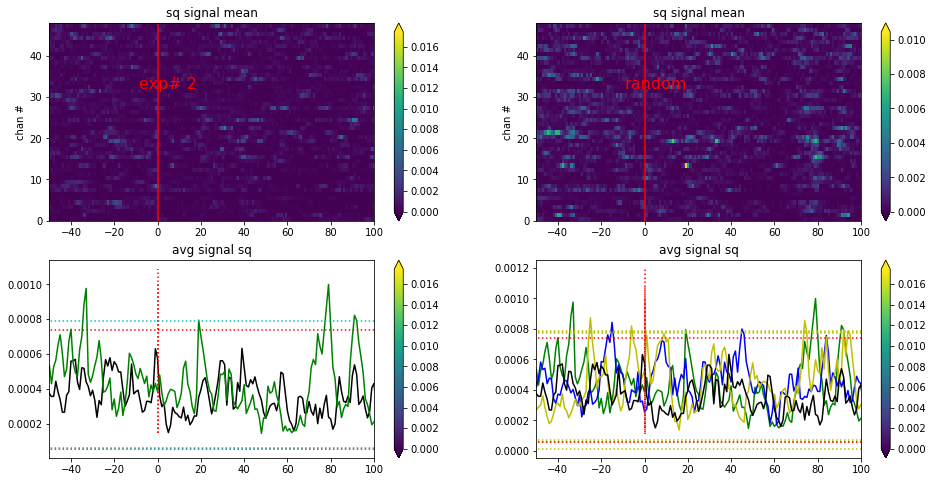


experiment number 3
	avg event period = 2.920118e+02 (min,max=(23, 1355)) over N=86 events, cv=1.0265


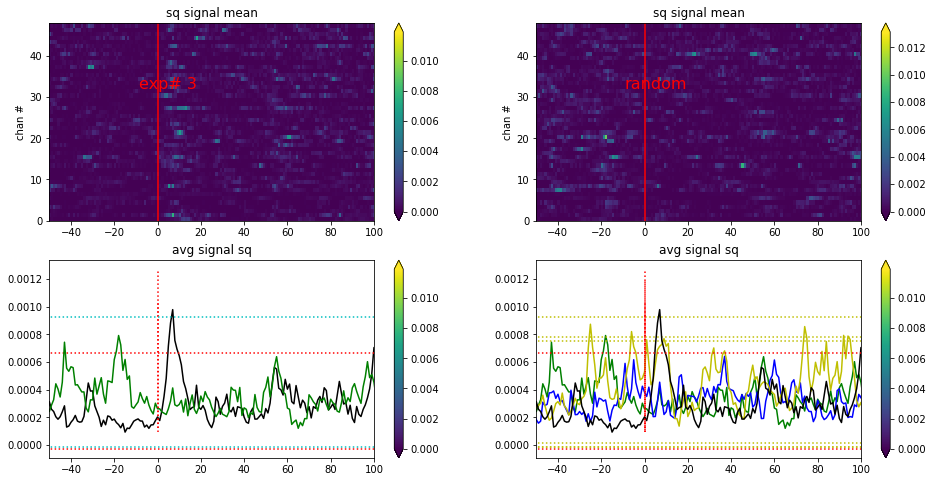

In [22]:

##################
# TODO: replace wiht a function

expt_n = np.arange(Nexpt)

# for trial-shifted surrogate
expt_n_ = np.roll(expt_n,2)

#time samples before and after event to collect
t_pre,t_post = (200,400)
times = np.arange(-t_pre,t_post)

# find overall correlation

for exp_n in expt_n:    
    #     Xraw = neurs[exp_n]
    #     X = deconvolve_experiment(Xraw)
    X = neurs_deconv[exp_n]

    events = behavs[exp_n]

    Nev = ev.shape[0]
    chans = X.shape[0]
    t_end = X.shape[1]
    t0 = 0
    print(f"\nexperiment number {exp_n}")
    print(iei_stats(events))

    trig_resp = get_event_triggered_array(events,X,times)
    # create an experiment shifted surrogate
    events_shift = behavs[expt_n_[exp_n]]
    surrogate_3 = get_event_triggered_array(events_shift,X,times)
    exp_n_ = expt_n_[exp_n]

    print
    
    # tetst some other "surrogates" in case the experimental trials give the events a regularity
    events_s1 = random_surrogate_Poisson(Nev,t0,t_end)
    surrogate_1 = get_event_triggered_array(events_s1,X,times)

    events_s2 = random_surrogate_IEImatched(events,t0,t_end)
    surrogate_2 = get_event_triggered_array(events_s2,X,times)

    
    #plot_event_triggered_plus_surrogates(exp_n,times,trig_resp,surrogate_1,surrogate_2,surrogate_3)
    plot_simple_summary_squared_resp(exp_n,times,trig_resp,surrogate_1,surrogate_2,surrogate_3,zoom=[-50,100])




# 3. IMPLICATIONS

Deconvolving the Calcium flourescnce signal increases Signal to Noise (S/N).  This technique uses some physical constraints from flourescence and Ca dynamics to model underlying neural signals.  Utilizing more a-priori knowledge helps!
    
The overall results were inconclusive.  Experiment #3 seemed to have some reliable event related signal, but additional analysis are needed to confirm and characterize the relationship.
    
The assumptions taken here of _averaging_ across channels (neurons) is naive.  Each neuron should be treated independently in further analysis.


# 4. NEXT-STEPS:  other analysis
- Cherry-pick channels with sufficient S/N to conclusively rule out the null hypothesis of indepencence between "behavioral events" and the neural recordings. 

- Developing a framework for analyzing individual channels opens up some potentially powerful analyses such as network analysis and other techniques to look at epresentations of activity in ensembles of several neurons could be non-linearly correlated ot the behavioral events.

- Refine the OASIS deconvolution.  Tuning the paramaters could imporove results.

- Spectral coherence analysis. The frequency domain might be more robust for estimating the associaiton between the events and signal. 

- Since we are operating at the limit of sigal to noise (S/N) developing a clear statistical test will be nescessary.  I have just used hueristics and rough 95% confidence intervals assuming an underlying Normal distributions to assess the null results.
    
    
### CAVEATS. 
In retrospect, choosing the highest signal to noise (S/N) channels should have been done at the first analysis.   Also in retrospect, attacking the simple core question with statistics -- is there a relationship between the events and signal? -- with a yes/no would have sped the overall analysis up.   More time was spend in exploring the data instead of answering the quesiton.   Although it seemd outside the scope and intention of this project, a brief discussion with the experimentalist or expert to give more context around the "behavioral events" would be invaluable. 
   
    

# 5. PROVENANCE.
    - make sure everything is here

In [23]:
import datetime
print(datetime.datetime.now())

2020-11-17 15:23:56.195048


In [24]:
# this could be made much simpler
!conda env export > environment.yml


In [25]:
!cat environment.yml

name: inscopix
channels:
  - anaconda
  - conda-forge
  - defaults
dependencies:
  - appnope=0.1.0=py38_1001
  - argon2-cffi=20.1.0=py38haf1e3a3_1
  - arrow=0.17.0=py38h32f6830_1
  - astroid=2.4.2=py38_0
  - async_generator=1.10=py_0
  - attrs=20.3.0=pyhd3eb1b0_0
  - backcall=0.2.0=py_0
  - binaryornot=0.4.4=py_1
  - blas=1.0=mkl
  - bleach=3.2.1=py_0
  - brotlipy=0.7.0=py38h94c058a_1001
  - bzip2=1.0.8=haf1e3a3_3
  - ca-certificates=2020.10.14=0
  - certifi=2020.6.20=py38_0
  - cffi=1.14.3=py38hed5b41f_0
  - chardet=3.0.4=py38h5347e94_1008
  - click=7.1.2=pyh9f0ad1d_0
  - cookiecutter=1.7.2=pyh9f0ad1d_0
  - cryptography=3.2.1=py38h5c1d3f9_0
  - cycler=0.10.0=py38_0
  - cython=0.29.21=py38hb1e8313_0
  - dbus=1.13.18=h18a8e69_0
  - decorator=4.4.2=py_0
  - defusedxml=0.6.0=py_0
  - entrypoints=0.3=py38_0
  - expat=2.2.10=hb1e8313_2
  - ffmpeg=4.2.3=hd0c0d6a_0
  - freetype=2.10.4=ha233b18_0
  - gettext=0.19.8.1=hb0f4f8b_2
  - glib=2.66.1=h9bbe63b_0
  - gmp=6.2.0=h4a8c4bd_2
  - gnutls=3.6

In [26]:
#AUTHOR: Andy Henrie, andy.henrie@gmail.com 